# Time series forecasting
In this project, we will forecast time series using historical data and (mostly) TensorFlow and compare the results between different neural network architecture and methodologies.
Now, let's try and predict the price of Bitcoin based on the (outdated) historical price of bitcoin.

### Other models that can be used for baselines and actual forecast
Other methods for time series forecast that can (but will not) be used during this project:
* Moving average
* ARIMA
* Tensorflow decision forests (random forest, gradient boosting trees)
* Facebook Kats
* Linkedin Greykite

## Get data
We'll be using data from the Tensorflow course github repo:

https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

In [238]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-09-30 03:16:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.003s  

2024-09-30 03:16:33 (63.3 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



## Import time series with pandas

In [239]:
# Import with pandas
import pandas as pd
# Let's read in out Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates = ["Date"],
                 index_col = ["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [240]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [241]:
# How many samples do we have?
len(df)

2787

we've collected the historical price of Bitcoin for the past 8 years, but there's 2787 samples.

Typically learning models like large dataset, but we only have a small dataset (which is a common issue in time series problems).

In [242]:
# Closing price only
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Text(0, 0.5, 'BTC Price')

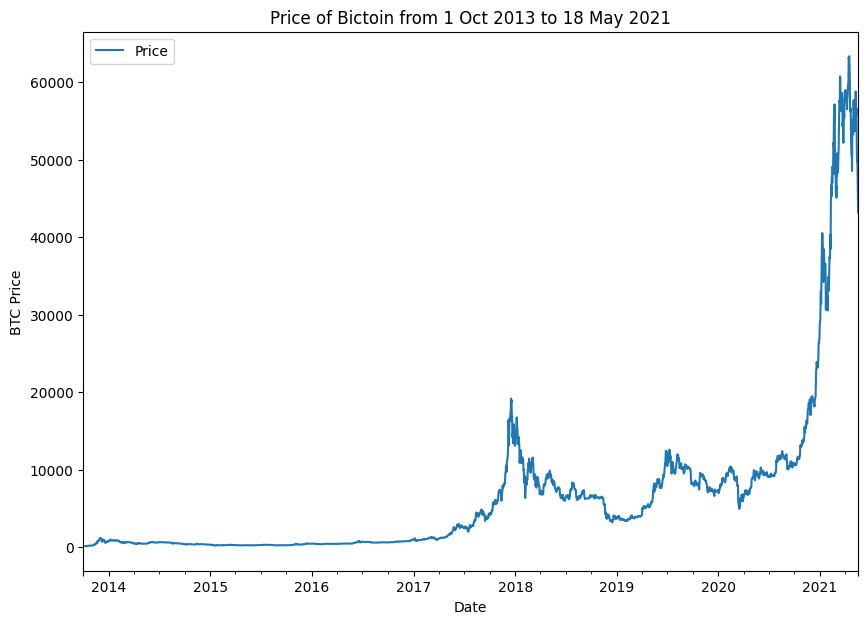

In [243]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize = (10, 7))
plt.title("Price of Bictoin from 1 Oct 2013 to 18 May 2021")
plt.ylabel("BTC Price")

## Importing time series data with Python's CSV module

In [244]:
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter = ",")
  next(csv_reader) #skip first line
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates
    btc_price.append(float(line[2]))

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

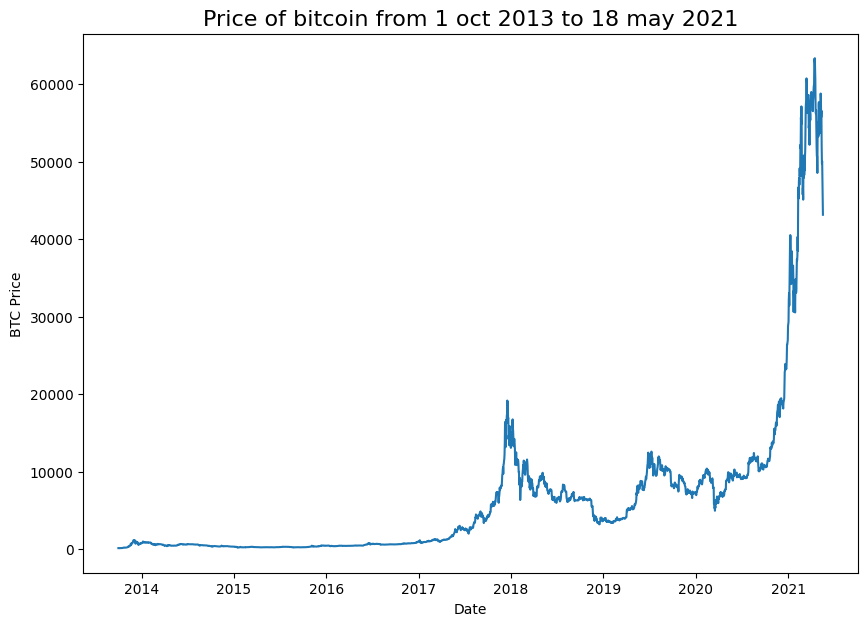

In [245]:
# Plot from CSV
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of bitcoin from 1 oct 2013 to 18 may 2021", fontsize = 16)
plt.xlabel("Date")

## Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [246]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [247]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size = 0.2,
                                                    random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

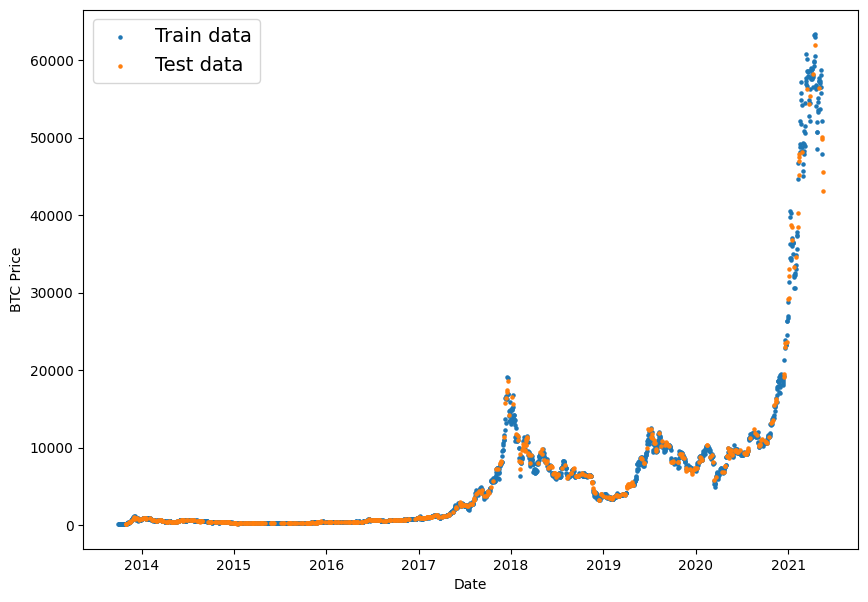

In [248]:
# Lets plot the wrong train and test splits
plt.figure(figsize = (10, 7))
plt.scatter(X_train, y_train, s = 5, label = "Train data")
plt.scatter(X_test, y_test, s = 5, label = "Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize = 14)
plt.show();


### Create train and test sets for time series (the right way)

In [249]:
# Create train and test splits
split_size = int(0.8 * len(prices))

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)


(2229, 558, 2229, 558)

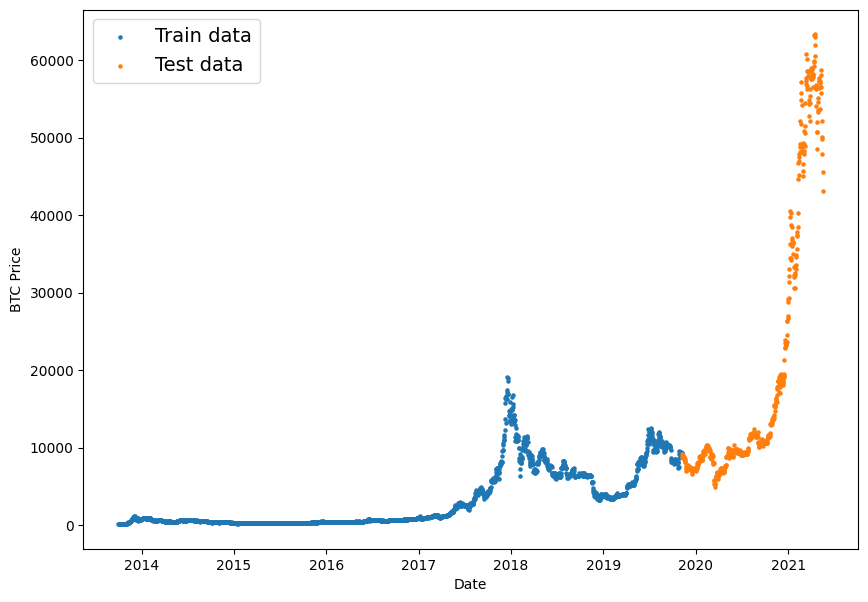

In [250]:
plt.figure(figsize = (10, 7))
plt.scatter(X_train, y_train, s = 5, label = "Train data")
plt.scatter(X_test, y_test, s = 5, label = "Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize = 14)
plt.show();

### Create plotting functions


In [251]:
# Create function to plot time series data
def plot_time_series(timesteps, values, format = ".", start = 0, end = None, label = None):
  '''
  Plots timesteps (a series of points in time) against values (a series of values across timesteps)

  Parameters
  ----------
  timesteps: array of timestep values
  values: array of values across time
  format: style of plot, default '.'
  start: where to start the plot
  end: where to end the plot
  label: label to show on plot about values
  '''

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], label = label)
  plt.xlabel("Time")
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize = 14)
  plt.grid(True)

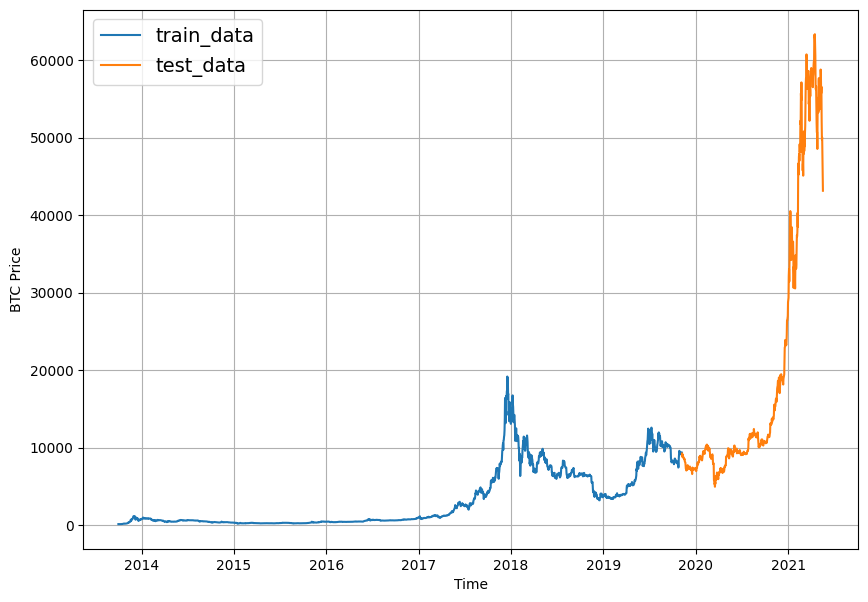

In [252]:
# Test out plotting function
plt.figure(figsize = (10, 7))
plot_time_series(timesteps = X_train, values = y_train,  label = 'train_data')
plot_time_series(timesteps = X_test, values = y_test, label = "test_data")

## Modelling Experiments

We've got some historical data, let's run a series of experiments and see which is best

Parameters:
* **Horizon:** Number of timesteps into the future we're going to predict
* **Window size:** Number of timesteps we're going to use to predict horizon

Modelling experiments we're running:
0. Naive model (baseline)
1. Dense model, horizon = 1, window = 7
2. Same as 1, different data
3. Same as 1, different data
4. Conv1D
5. LSTM
6. Same as 1 (but with multivariate data)
7. N-BEATS algorithm
8. Ensemble
9. Future prediction model
10. Same as 1 (but with turkey data introduced)

## Model 0: Naive forecast
The formula for a naive model looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In [253]:
# Create naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

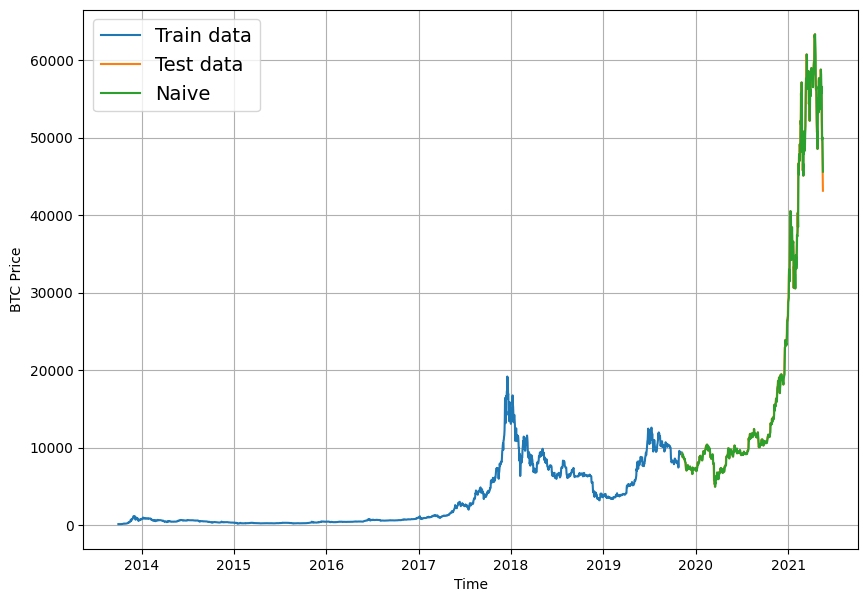

In [254]:
# Plot the forecast
plt.figure(figsize = (10, 7))
plot_time_series(timesteps = X_train, values = y_train, label = 'Train data')
plot_time_series(timesteps = X_test, values = y_test, label = 'Test data')
plot_time_series(timesteps = X_test[1:], values = naive_forecast, format = "-", label = 'Naive')

## Evaluating a time series model

What are we doing?

We're predicting a number, so it is a regression problem. So we'll need to use some regression metrics.

* MAE: mean absolute error
* MSE: mean square error
* RMSE: root mean squared error
* MAPE/sMAPE: (symmetric) mean absolute percentage error
* MASE: mean absolute scaled error

**Note:** For all of there metrics lower is better

In [255]:
import tensorflow as tf

In [256]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # Our seasonality is one day (hence the shift of 1)
  return mae/mae_naive_no_season

In [257]:
mean_absolute_scaled_error(y_true = y_test[1:], y_pred = naive_forecast).numpy()

0.9995699939182624

In [258]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mse = tf.reduce_mean(tf.square(y_true - y_pred)) # emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.reduce_mean(tf.abs(y_true - y_pred) / y_true)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [259]:
naive_results = evaluate_preds(y_true = y_test[1:], y_pred = naive_forecast)

## Windowing our dataset


In [260]:
# What we want to do to window the data
print(f"Predict {btc_price[7]} using {btc_price[:7]}")

Predict 123.033 using [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795]


In [261]:
# Setup global variables
HORIZON = 1     # Predict next day
WINDOW_SIZE = 7 # Using previous week

In [262]:
# Create function to label windowed data
def get_labelled_window(x, horizon = HORIZON):
  """
  Creates labels for windowed dataset.
  E.g. if horizon = 1.
  input = [0, 1, 2, 3, 4, 5, 6] -> output = [[0, 1, 2, 3, 4, 5, 6], [7]]
  """
  return x[:, :-horizon], x[:, -horizon]

In [263]:
# Test the function
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8), axis = 0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> label: 7


Now, we'll do it across all of our time series

Our function will:
1. Create a window step of specific window size
2. Use Numpy indexing to create a 2D array of multiple window steps.
3. Uses the 2D array to index on a time series
4. Uses our get labelled windows funtion we created above to turn the window steps into windows with a specified horizon.

In [264]:
import numpy as np
# Create function to view NumPy arrays as windows
def make_windows(x, window_size, horizon):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_window(windowed_array, horizon=horizon)

  return windows, labels

In [265]:
full_windows, full_labels = make_windows(prices, window_size  =WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [266]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> label: 123.033
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> label: 124.049
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> label: 125.96116


**NOTE:** The tf.keras.preprocessing.timeseries_dataset_from_array() does exactly the same as above

In [267]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [268]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [269]:
# Visualize
train_windows[:5]

array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ],
       [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
        123.033  ],
       [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
        124.049  ],
       [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
        125.96116],
       [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
        125.27966]])

In [270]:
test_windows[:5]

array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
        9335.75240233, 9226.48582088, 8794.35864452],
       [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
        9226.48582088, 8794.35864452, 8798.04205463],
       [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
        8794.35864452, 8798.04205463, 9081.18687849],
       [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
        8798.04205463, 9081.18687849, 8711.53433917],
       [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
        9081.18687849, 8711.53433917, 8760.89271814]])

## Make a modelling checkpoint

Because of model performance fluctuation, we'll write a model check point so we can compare the best against the best

In [271]:
import os

# Create a function to implement a modelcheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path = "model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name) + ".keras",
                                            verbose = 0,
                                            save_best_only = True)

## Model 1: Dense model (window  = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation
* Adam optimization and MAE loss function
* Batch size of 128
* 100 epochs

In [272]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON, activation = "linear")
], name = "model_1_dense")

# 2. Compile the model
model_1.compile(loss = "mae",
                optimizer = "Adam",
                metrics = ["mae", "mse"])

# 3. Fit the model
model_1.fit(x = train_windows,
            y = train_labels,
            epochs = 100,
            verbose = 0,
            batch_size = 128,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_1.name)])

In [273]:
# Evaluate the model on test data
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 283.3661 - mae: 283.3661 - mse: 345307.5000


[564.7251586914062, 564.7251586914062, 1164158.0]

In [274]:
# Load in the best performing model
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 283.3661 - mae: 283.3661 - mse: 345307.5000


[564.7251586914062, 564.7251586914062, 1164158.0]

## Making forecasts with the model (on the test dataset)

To make pseudoforecasts on the test dataset, we'll write a function to:

1. Take in a trained model
2. Takes in some input data
3. Passes the input data to the model's predict() method
4. Returns the predictions

In [275]:
def make_preds(model, input_data):
  """
  Uses model to make predictions
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [276]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8881.63  , 8802.125 , 9022.8125, 8795.756 , 8773.376 , 8739.578 ,
        8689.801 , 8551.831 , 8470.332 , 8534.123 ], dtype=float32)>)

In [277]:
# Evaluate preds
model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_1_preds)
model_1_results

{'mae': 564.72516,
 'mse': 1164158.1,
 'rmse': 1078.9615,
 'mape': 0.025392022,
 'mase': 0.99206567}

In [278]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 0.02516525,
 'mase': 0.99957}

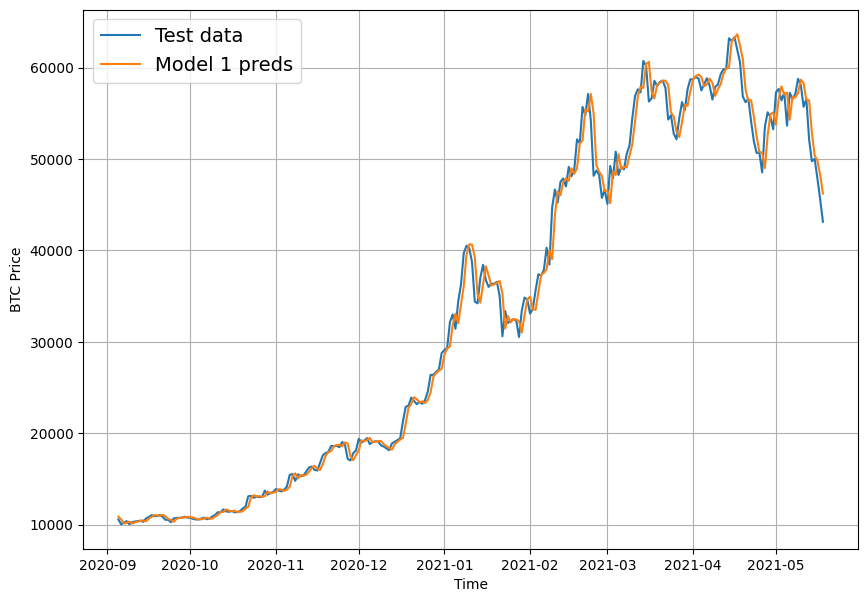

In [279]:
# Let's plot the predictions
offset = 300
plt.figure(figsize = (10,7))

# Account for the test_window offset and index into test_labels to ensure correcto plotting
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels,
                 start = offset,
                 label = "Test data")
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = model_1_preds,
                 start = offset,
                 label = "Model 1 preds")

## Model 2: Dense (window = 30, horizon = 1)

In [280]:
HORIZON = 1       # Predict one day at a time
WINDOW_SIZE = 30  # Use 30 timesteps

In [281]:
# Make windows data with appripriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [282]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows = full_windows,
                                                                                labels = full_labels,
                                                                                test_split = 0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [283]:
# Set random seed
tf.random.set_seed(42)

# Build the model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON)
], name = "model_2_dense")

# Compile the model
model_2.compile(loss = "mae",
                optimizer = "Adam")

# Fit the model
model_2.fit(x = train_windows,
            y = train_labels,
            epochs = 100,
            verbose = 0,
            batch_size = 128,
            validation_data = (test_windows, test_labels),
            validation_steps = len(train_labels),
            callbacks = [create_model_checkpoint(model_name = model_2.name)])

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [284]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 411.9453


767.9497680664062

In [285]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 313.9676


612.7703247070312

In [286]:
# Get the forecast predictions
model_2_preds = make_preds(model_2,
                           input_data = test_windows)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [287]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_2_preds)
model_2_results

{'mae': 612.7704,
 'mse': 1278163.6,
 'rmse': 1130.559,
 'mape': 0.028069109,
 'mase': 1.0711286}

In [288]:
model_1_results

{'mae': 564.72516,
 'mse': 1164158.1,
 'rmse': 1078.9615,
 'mape': 0.025392022,
 'mase': 0.99206567}

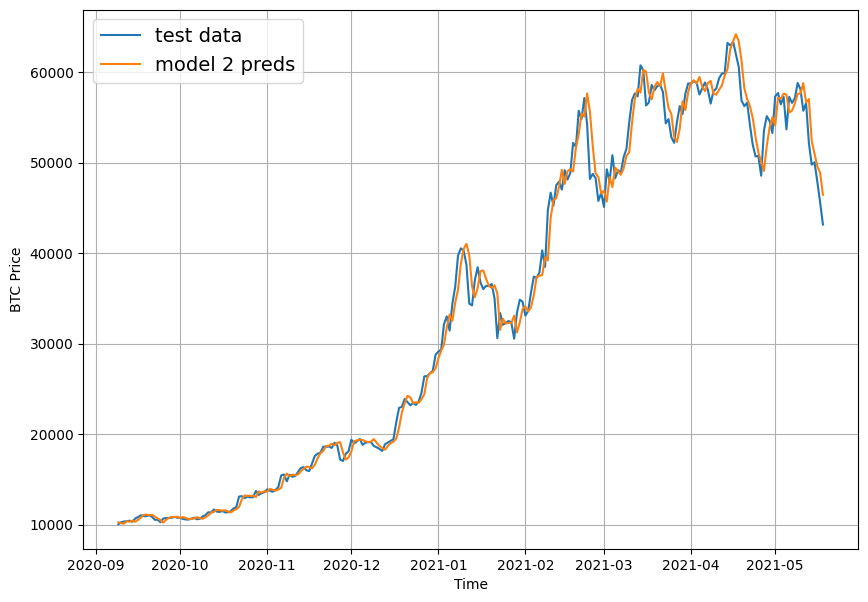

In [289]:
offset = 300
plt.figure(figsize = (10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps = X_test[-len(test_windows):], values = test_labels, start = offset, label = "test data")
plot_time_series(timesteps = X_test[-len(test_windows):], values = model_2_preds, start = offset, format = "-", label = "model 2 preds")

## Model 3: Dense: (window size of 30 and horizon of 7)

In [290]:
WINDOW_SIZE = 30
HORIZON = 7

In [291]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [292]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels), train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

(2200, 551, 2200, 551, (2200, 30), (551, 30), (2200,), (551,))

In [293]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(1)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, tf.squeeze(test_labels)),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])


In [294]:
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 334.2026


651.3255615234375

In [295]:
model_3 = tf.keras.models.load_model("/content/model_experiments/model_3_dense.keras")
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 320.3115


612.4968872070312

In [296]:
model_3_preds = make_preds(model_3, test_windows)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


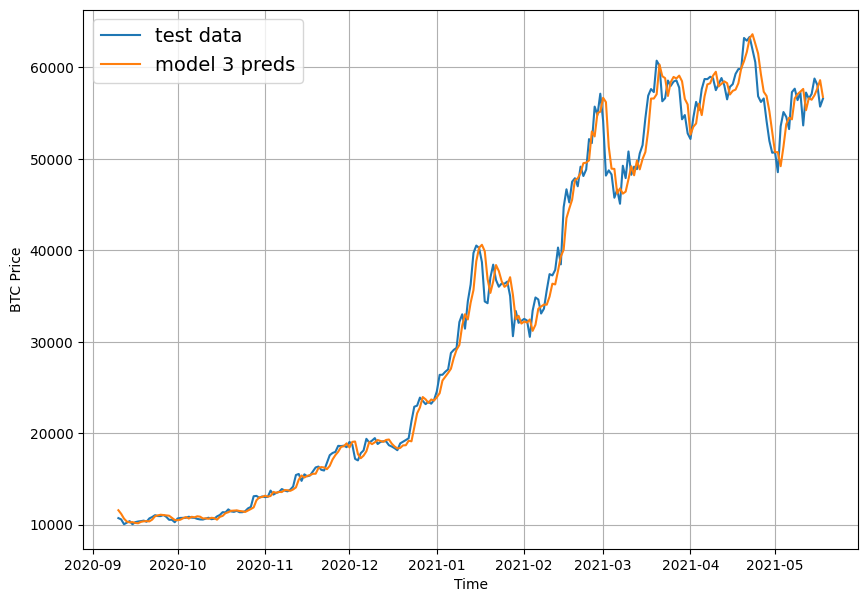

In [297]:
# Plot the predictions
offset = 300
plt.figure(figsize = (10, 7))

plot_time_series(timesteps = X_test[-len(test_windows):], values = test_labels, start = offset, label = "test data")
plot_time_series(timesteps = X_test[-len(test_windows):], values = model_3_preds, start = offset, format = "-", label = "model 3 preds")

In [298]:
model_3_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_3_preds)
model_3_results

{'mae': 612.4968,
 'mse': 1247528.0,
 'rmse': 1116.9279,
 'mape': 0.02859349,
 'mase': 1.1155976}

These results only show how to NOT approach time series forecasting with neural networks. Since autocorrelation is an important factor to consider in these kind of predictions, we'll need some other type of architecture for sequences.

## Model 4: Conv 1D

In [299]:
HORIZON = 1
WINDOW_SIZE = 7

In [300]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [301]:
# Make train and test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

We need an input shape of: (batch_size, timesteps, input_dim) to use a Conv1D layer

In [302]:
# Check data input shape
train_windows[0].shape

(7,)

In [303]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make up for the extra dimension
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [304]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis = 1))

In [305]:
# Test our lambda layer
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape: \n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: 
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [306]:
# Create a conv 1D model
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Input(shape=(7,)),
    expand_dims_layer,
    layers.Conv1D(filters = 128, kernel_size = 5, padding = "causal", activation = "relu"),
    layers.Dense(1)
], name = "model_4_conv_1D")

model_4.compile(loss = "mae",
                optimizer = "Adam",
                )

model_4.build(input_shape=(None,) + (7,))

model_4.fit(train_windows,
            train_labels,
            batch_size = 128,
            verbose = 0,
            epochs = 100,
            validation_data=(test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_4.name)]
            )

In [307]:
model_4.summary()

Model: "model_4_conv_1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)                    │ (None, 1, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1, 128)              │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_191 (Dense)                    │ (None, 1, 1)                │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,213 (55.52 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,476 (37.02 KB)

In [308]:
# Evaluate the model
model_4.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9551.0029


17024.73828125

In [309]:
model_4_preds = make_preds(model_4, test_windows)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


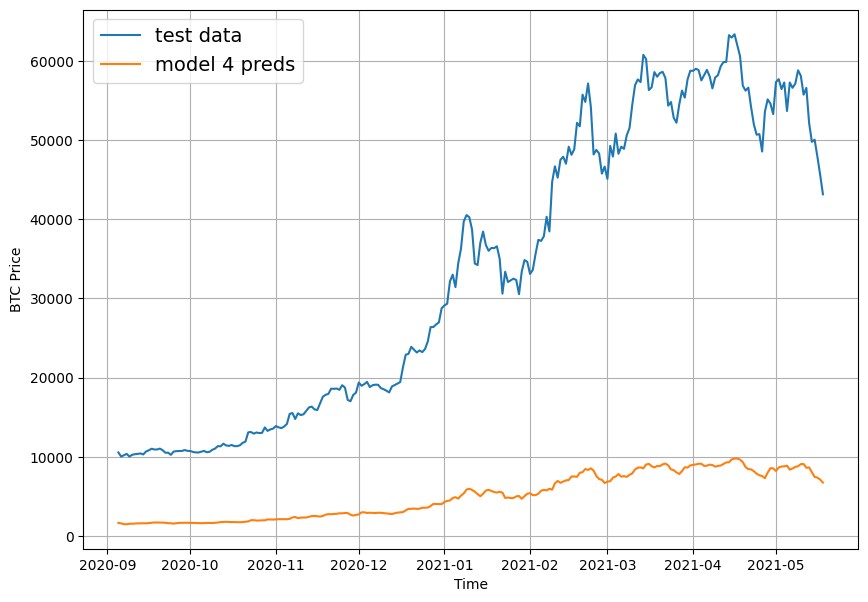

In [310]:
offset = 300
plt.figure(figsize = (10, 7))

plot_time_series(timesteps = X_test[-len(test_windows):], values = test_labels, start = offset, label = "test data")
plot_time_series(timesteps = X_test[-len(test_windows):], values = model_4_preds, start = offset, format = "-", label = "model 4 preds")

In [311]:
model_4_results = evaluate_preds(y_true = test_labels,
                                 y_pred = model_4_preds)
model_4_results

{'mae': 17024.738,
 'mse': 510820350.0,
 'rmse': 22601.336,
 'mape': 0.84629405,
 'mase': 29.90775}

Terrible result, on to the next model...

## Model 5: RNN (LSTM)

In [312]:
tf.random.set_seed(42)

# Building using the functional API
inputs = layers.Input(shape = (WINDOW_SIZE,))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis = 1))(inputs)
x = layers.LSTM(128, activation = "relu")(x)
output = layers.Dense(HORIZON, activation = "relu")(x)
model_5 = tf.keras.Model(inputs = inputs, outputs = output, name = "model_5_LSTM")

# Compile
model_5.compile(loss = "mae",
                optimizer = "Adam")

# Fit
model_5. fit(train_windows,
             train_labels,
             epochs = 100,
             verbose = 0,
             batch_size = 128,
             validation_data = (test_windows, test_labels),
             callbacks = [create_model_checkpoint(model_name = model_5.name)])

In [313]:
# Evaluate
model_5.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 292.5357


586.4066162109375

In [314]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8865.889, 8768.258, 8940.951, 8735.484, 8700.082], dtype=float32)>

In [315]:
model_5_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_5_preds)
model_5_results

{'mae': 586.4067,
 'mse': 1215315.4,
 'rmse': 1102.4135,
 'mape': 0.026307957,
 'mase': 1.0301541}

## Make a multivariate time series dataset

We will now take into account the bitcoin halving event

In [316]:
# Lets make a multiariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [317]:
# We will use halving data from october 2013 onwards
block_reward_1 = 25   # 8 November 2012
block_reward_2 = 12.5 # 9 july 2016
block_reward_3 = 6.25 # 18 May 2020

# Block reward dates
block_reward_1_datetime = np.datetime64("2012-11-28")
block_reward_2_datetime = np.datetime64("2016-07-09")
block_reward_3_datetime = np.datetime64("2020-05-18")

In [318]:
# Create date ranges of where specific block reward values shoud be
block_reward_1_days = (block_reward_2_datetime - bitcoin_prices.index[0]).days
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_1_days, block_reward_2_days

(1012, 2421)

In [319]:
# Add i a block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["Block_reward"] = None

# Add in a block reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_1_days, -1] = block_reward_1
bitcoin_prices_block.iloc[block_reward_1_days:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:, -1] = block_reward_3

In [320]:
bitcoin_prices_block.tail()

,Price,Block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


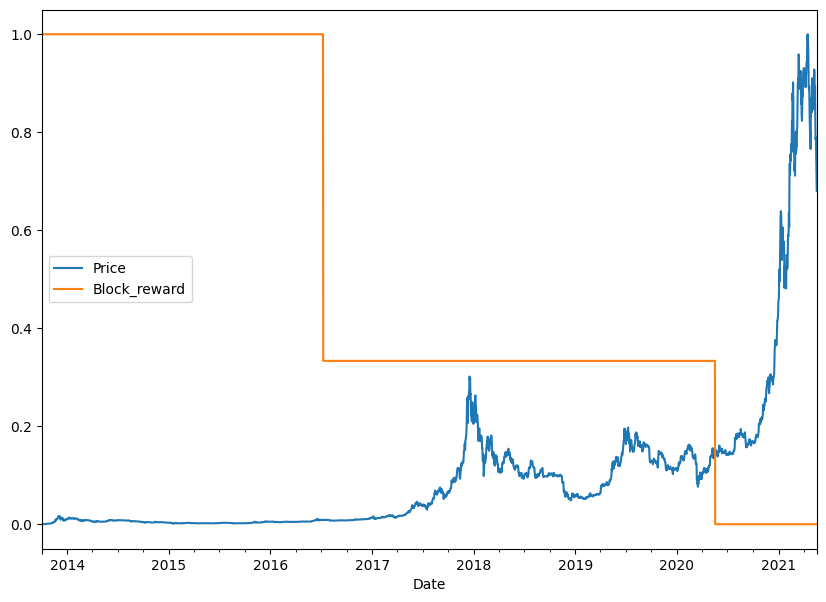

In [321]:
# Plot the block reward vs price relationship
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "Block_reward"]]),
                                     columns = bitcoin_prices_block.columns,
                                     index = bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize = (10, 7));

## Making a windowed dataset with pandas
Since our functions only work with univariate data, we'll need to to new ones to handle bivariate data

In [322]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [323]:
# Make a copy of the bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods = i+1)

bitcoin_prices_windowed.head(10)

,Price,Block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset directly from a pandas dataset.

In [324]:
# Create X windows and Y horizon features
X = bitcoin_prices_windowed.dropna().drop("Price", axis = 1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,Block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [325]:
y.head()

,Price
Date,
2013-10-08,123.032997
2013-10-09,124.049004
2013-10-10,125.961159
2013-10-11,125.279663
2013-10-12,125.927498


In [326]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [327]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2224, 8), (556, 8), (2224,), (556,))

## Model 6: Dense with multivariate data

In [328]:
# Set seed
tf.random.set_seed(42)

# Create model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON)
], name = "Model_6_multivariate")

# Compile model
model_6.compile(loss = "mae",
                optimizer = "Adam")

model_6.fit(X_train,
            y_train,
            epochs = 100,
            batch_size = 128,
            verbose = 0,
            validation_data = (X_test, y_test),
            callbacks = [create_model_checkpoint(model_name = model_6.name)])

In [329]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 292.9464


579.787841796875

In [330]:
model_6 = tf.keras.models.load_model("/content/model_experiments/Model_6_multivariate.keras")
model_6.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 281.7933


564.3955078125

In [331]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds.shape

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


TensorShape([556])

In [332]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true = y_test,
                                 y_pred = model_6_preds)
model_6_results

{'mae': 564.39557,
 'mse': 1158097.1,
 'rmse': 1076.1492,
 'mape': 0.025252797,
 'mase': 0.99148667}

In [333]:
model_1_results

{'mae': 564.72516,
 'mse': 1164158.1,
 'rmse': 1078.9615,
 'mape': 0.025392022,
 'mase': 0.99206567}

## Model 7: N-BEATS algorithm

Recreated from the paper by Cornell University: https://arxiv.org/pdf/1905.10437.pdf

### Building and testing the N-BEATS block layer
Because this layer doesn't exist in tensorflow, we've got to create it using subclassing.


In [334]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers with RELU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation = "relu") for _ in range(n_layers)]
    # Output of block is a theta layer of linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation = "linear", name = "Theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Let's test our new class

To do so we'll create some dummy inputs and outputs

In [335]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size = WINDOW_SIZE,
                                       theta_size = WINDOW_SIZE + HORIZON,
                                       horizon = HORIZON,
                                       n_neurons = 128,
                                       n_layers = 4)

In [336]:
# Create dummy inputs (careful with sizes)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis = 0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [337]:
# Pass dummy inputs to NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.5930195  -0.08157411 -0.24678533 -0.27187467  0.01626891 -0.5610943
 -0.041803  ]
Forecast: -0.7117300033569336


### Preparing the data

In [338]:
HORIZON = 1
WINDOW_SIZE = 7

In [339]:
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+ {i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods = i+1)
bitcoin_prices_nbeats.head(10)

,Price,Price+ 1,Price+ 2,Price+ 3,Price+ 4,Price+ 5,Price+ 6,Price+ 7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [340]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis = 1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

In [341]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (Features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [342]:
# Values from NBEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before creating our N-BEATS model, we need two layers for the residual connections.

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture.

In [343]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fititng the N-BEATS algorithm
1. Setup an instance of the N-BEATS block layer
2. Create an input layer for the N-BEATS stack
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Uthe for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the modle inputs and outputs together using tf.keras.model()
8. Compile the model with MAE loss and Adam optimizer with default setting as per section 5.2 of N-BEATS paper
9. Fit the model for 5000 epochs, using some callbacks:
  * Early Stopping
  * Reduce LR on Plateau

In [344]:
%%time
tf.random.set_seed(42)

# 1. Setup an instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size = INPUT_SIZE,
                                 theta_size = THETA_SIZE,
                                 horizon = HORIZON,
                                 n_neurons = N_NEURONS,
                                 n_layers = N_LAYERS,
                                 name = "InitialBlock")
# 2. Create input to stack
stack_input = layers.Input(shape = (INPUT_SIZE,), name = "stack input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # First stack is already created in (3)

  # 5. Use the N-BeatsBlock to claculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size = INPUT_SIZE,
      theta_size = THETA_SIZE,
      horizon = HORIZON,
      n_neurons = N_NEURONS,
      n_layers = N_LAYERS,
      name = f"NBeatsBlock_{i}"
  )(residuals) # Pass on the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name = f"Subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name = f"Add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs = stack_input, outputs = forecast, name = "model_7_NBEATS")

# 8. Compile the model
model_7.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam())

# 9. Fit the model
model_7.fit(train_dataset,
            epochs = N_EPOCHS,
            validation_data = test_dataset,
            verbose = 0,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                          patience = 200,
                                                          restore_best_weights = True),
                         tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                             patience = 100,
                                                             )])

CPU times: user 4min 21s, sys: 5.05 s, total: 4min 27s
Wall time: 5min 23s


In [345]:
# Evaluate on the test dataset
model_7.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 573.0100


573.010009765625

In [346]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [347]:
model_7_results = evaluate_preds(y_true = y_test,
                                 y_pred = model_7_preds)
model_7_results

{'mae': 573.0101,
 'mse': 1180815.4,
 'rmse': 1086.6533,
 'mape': 0.025724163,
 'mase': 1.0066199}

In [348]:
model_1_results

{'mae': 564.72516,
 'mse': 1164158.1,
 'rmse': 1078.9615,
 'mape': 0.025392022,
 'mase': 0.99206567}

In [349]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 0.02516525,
 'mase': 0.99957}

### Plotting the N-BEATS architecture

In [350]:
# Summarize the N-BEATS model and inspect the architecture
model_7.summary()

Model: "model_7_NBEATS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ stack input (InputLayer)  │ (None, 7)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ InitialBlock              │ [(None, 7), (None, 1)] │        796,168 │ stack input[0][0]      │
│ (NBeatsBlock)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NBeatsBlock_0             │ [(None, 7), (None, 1)] │        796,168 │ InitialBlock[0][0]     │
│ (NBeatsBlock)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Subtract_0 (Subtract)     │ (None, 7)              │              0 │ InitialBlock[0][0],    │
│                           │                        │                │ NBeatsBlock_0[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NBeatsBlock_1             │ [(None, 7), (None, 1)] │        796,168 │ Subtract_0[0][0]       │
│ (NBeatsBlock)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Subtract_1 (Subtract)     │ (None, 7)              │              0 │ Subtract_0[0][0],      │
│                           │                        │                │ NBeatsBlock_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NBeatsBlock_2             │ [(None, 7), (None, 1)] │        796,168 │ Subtract_1[0][0]       │
│ (NBeatsBlock)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Subtract_2 (Subtract)     │ (None, 7)              │              0 │ Subtract_1[0][0],      │
│                           │                        │                │ NBeatsBlock_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NBeatsBlock_3             │ [(None, 7), (None, 1)] │        796,168 │ Subtract_2[0][0]       │
│ (NBeatsBlock)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Subtract_3 (Subtract)     │ (None, 7)              │              0 │ Subtract_2[0][0],      │
│                           │                        │                │ NBeatsBlock_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NBeatsBlock_4             │ [(None, 7), (None, 1)] │        796,168 │ Subtract_3[0][0]       │
│ (NBeatsBlock)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Subtract_4 (Subtract)     │ (None, 7)              │              0 │ Subtract_3[0][0],      │
│                           │                        │                │ NBeatsBlock_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NBeatsBlock_5             │ [(None, 7), (None, 1)] │        796,168 │ Subtract_4[0][0]       │
│ (NBeatsBlock)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Subtract_5 (Subtract)

 Total params: 71,655,122 (273.34 MB)

 Trainable params: 23,885,040 (91.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,770,082 (182.23 MB)

## Model 8: Creating an ensemble

An ensemble leverages the wisdom of the crowd effect.

### Constructing and fitting an ensemble of models

In [351]:
def get_ensemble_models(horizon = HORIZON,
                        train_data = train_dataset,
                        test_data = test_dataset,
                        num_iter = 10,
                        num_epochs = 1000,
                        loss_fns = ["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model
      model = tf.keras.Sequential([
          # Initialize dense layers with normal distributions
          layers.Dense(128, kernel_initializer = "he_normal", activation = "relu"),
          layers.Dense(128, kernel_initializer = "he_uniform", activation = "relu"),
          layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss = loss_function,
                    optimizer = "Adam",
                    metrics = ["mae", "mse"])

      # Fit the current model
      model.fit(train_data,
                epochs = num_epochs,
                verbose = 0,
                validation_data = test_data,
                callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                              patience = 200,
                                                              restore_best_weights = True),
                             tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                                  patience = 100,
                                                                  verbose = 1)])
      # Append the models
      ensemble_models.append(model)
  return ensemble_models

In [352]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter = 5,
                                      num_epochs = 1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 367: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 467: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 450: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 550: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 125: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 244: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 344: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 669: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 769: ReduceLROnPl

In [353]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [354]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models = ensemble_models,
                                     data = test_dataset)
ensemble_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
CPU times: user 2.04 s, sys: 43.2 ms, total: 2.08 s
Wall time: 2.11 s


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8782.001,  8748.134,  8999.999, ..., 50671.03 , 48339.082,
        46607.8  ],
       [ 8740.843,  8814.947,  9046.499, ..., 50402.582, 48113.53 ,
        46453.418],
       [ 8804.42 ,  8777.771,  9060.335, ..., 50214.97 , 48536.883,
        46031.332],
       ...,
       [ 8804.472,  8803.539,  9090.844, ..., 50554.266, 48340.69 ,
        46720.543],
       [ 8760.65 ,  8761.797,  9037.542, ..., 50086.863, 48285.395,
        46222.312],
       [ 8786.047,  8815.457,  9071.453, ..., 50113.574, 48351.254,
        45981.844]], dtype=float32)>

In [355]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true = y_test,
                                  y_pred =ensemble_preds)
ensemble_results

{'mae': 580.02747,
 'mse': 1178485.1,
 'rmse': 1085.5806,
 'mape': 0.026307825,
 'mase': 1.0189476}

In [356]:
# Remember we made several models...
ensemble_mean = np.mean(ensemble_preds, axis = 0)
ensemble_median = np.median(ensemble_preds, axis = 0)

In [357]:
ensemble_results = evaluate_preds(y_true = y_test,
                                  y_pred =ensemble_median)
ensemble_results

{'mae': 569.5616,
 'mse': 1149231.9,
 'rmse': 1072.0223,
 'mape': 0.025621867,
 'mase': 1.000562}

In [358]:
ensemble_results = evaluate_preds(y_true = y_test,
                                  y_pred =ensemble_mean)
ensemble_results

{'mae': 568.2369,
 'mse': 1142589.4,
 'rmse': 1068.9197,
 'mape': 0.025608126,
 'mase': 0.9982348}

In [359]:
model_1_results

{'mae': 564.72516,
 'mse': 1164158.1,
 'rmse': 1078.9615,
 'mape': 0.025392022,
 'mase': 0.99206567}

### Plotting the prediction intervals of our ensemble

Instead of making point predictions, we'll now get these predictions within a range so it becomes more "accurate".

One way to get the 95% confidence prediction intervalls for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models.
2. Measure the standard deviation of the predictions
3. Multiply the standard deciation by 1.96 (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations from the mean)
4. To get the upper and lower bounds, add and substract the value obtained in (3) to the mean/median of the predictions made in (1).

In [360]:
# Fins upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1.Take the predictions from a number of randomly initialized models

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis = 0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis = 0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [361]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds = ensemble_preds)

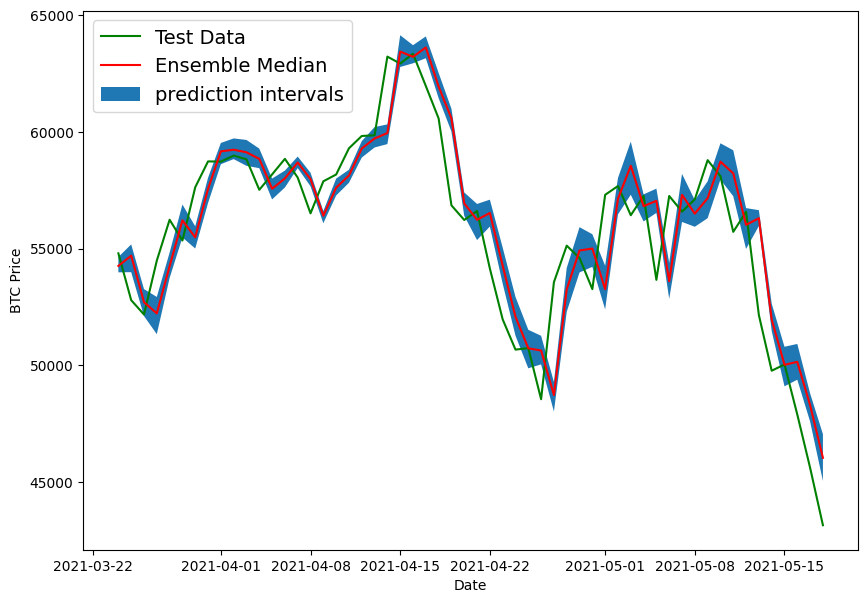

In [362]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis = 0)

# Plot the median of our ensemble preds along with the prediction intervals
offset = 500
plt.figure(figsize = (10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label = "Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "r", label = "Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")

# To plot the upper and lower bounds lets use fill_between
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:],
                 label = "prediction intervals")
plt.legend(loc = "upper left", fontsize = 14)

So far all of our model predictions have been lagging behind the test data...

As if they're just replicating whatever the naive model was doing.

**NOTE:** This particular prediction was made under the assumption that the data came from a normal distribution.

## Model 9: Train a model on the full historical data to make predictiond into the future

So far all of our models have predicted on the test dataset, however this is only the pseudofuture.

We will now predict into what the dataset would consider as the actual future.

In [363]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "Block_reward"], axis = 1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [364]:
X_all[:10], y_all[:10]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866],
        [125.9275 , 125.27966, 125.96116, 124.049  , 123.033  , 121.795  ,
         120.65533],
        [126.38333, 125.9275 , 125.27966, 125.96116, 124.049  , 123.033  ,
         121.795  ],
        [135.24199, 126.38333, 125.9275 , 125.27966, 125.96116, 124.049  ,
         123.033  ],
        [133.20333, 135.24199, 126.38333, 125.9275 , 125.27966, 125.96116,
         124.049  ],
        [142.76333, 133.20333, 135.24199, 126.38333, 125.9275 , 125.27966,
         125.96116]]),
 array([123.033  , 124.049  , 125.9611

In [365]:
# Turn data into efficient running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [366]:
tf.random.set_seed(42)

# Create model (nice and simple)
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss = "mae",
                optimizer = "Adam")

# Fit the model on all of the data to make future predictions
model_9.fit(dataset_all,
            verbose = 0,
            epochs = 100)

### Make predictions into the future

In [367]:
# How many timesteps to predict into the future
INTO_FUTURE = 14

To make predictions into the future we want a funtion which:

1. Takes an input:
  * A list of values
  * A trained model
  * A window into the future to predict
  * The window size a model was trained on

2. Creates an empty list for future forecasts and extracts the last window size values from the input values.
3. Loop INTO_FUTURE times makeing a prediction on WINDOW_SIZE sequences which update to remove the first value and append the latest prediction.

In [368]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size = WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, atering the data which gets predicted on each time
  for i in range(INTO_FUTURE):
    # Predict on the last window then append it again until our model stops
    future_pred = model.predict(tf.expand_dims(last_window, axis = 0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()} \n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  return future_forecast


In [369]:
# Make forecast into the future
future_forecast = make_future_forecasts(values = y_all,
                                        model = model_9,
                                        into_future = INTO_FUTURE,
                                        window_size = WINDOW_SIZE
                                        )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 56181.94921875 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 56181.94921875] -> Prediction: 51175.21484375 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 56181.94921875 51175.21484375] -> Prediction: 49292.45703125 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 56181.94921875 51175.21484375 49292.45703125] -> Prediction: 50385.61328125 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 56181.94921875
 51175.21484375 49292.45703125 50385.61328125] -> Prediction: 45851.828125 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [370]:
future_forecast

[56181.95,
 51175.215,
 49292.457,
 50385.613,
 45851.83,
 46953.31,
 47478.746,
 54923.34,
 50976.434,
 48924.8,
 49895.523,
 45588.164,
 48571.246,
 50076.918]

In [371]:
from datetime import timedelta

def get_future_dates(start_date, into_future, offset =1):
  """
  Returns array of datetime values ranging from start_date to start_date + into_future
  """
  start_date = start_date + timedelta(days = offset)
  end_date = start_date + timedelta(days = into_future)
  return np.arange(start_date, end_date, dtype = "datetime64[D]")

In [372]:
# Last timestep of timesteps
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [373]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date = last_timestep,
                                   into_future = INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [374]:
# Insert last timestep final price into next time steps and future forecasts so the plot doesnt look janky
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 56181.95 , 51175.215, 49292.457, 50385.613, 45851.83 ,
        46953.31 , 47478.746, 54923.34 , 50976.434, 48924.8  , 49895.523,
        45588.164, 48571.246, 50076.918], dtype=float32))

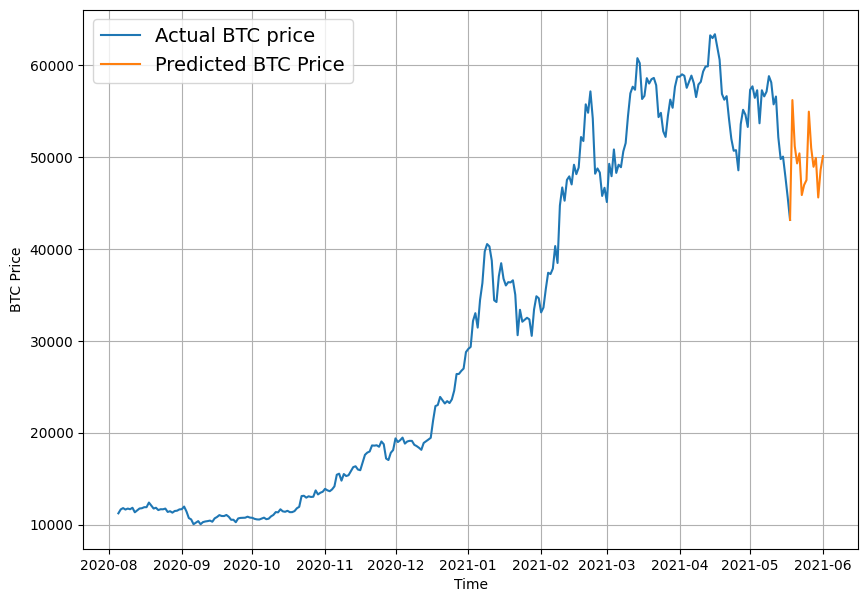

In [375]:
# Plot future prices of predictions of bitcoin
plt.figure(figsize = (10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start = 2500, format = "-", label = "Actual BTC price")
plot_time_series(next_time_steps, future_forecast, format = "-", label = "Predicted BTC Price")

## Model 10: Why forecasting is oftentimes BS (The turkey problem)

Imagine the graph of the quality of life of a turkey. It will probably keep on increasing... until thanksgiving. This section is to demonstrate how models fail to predict catastrophic events and why they are not as reliable as one would think.

In [376]:
# Let's introduce a turkey problem to our BTC data
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1]/1000

In [377]:
# Manufacture an extra price on the end
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 43.1444712908603]

In [378]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

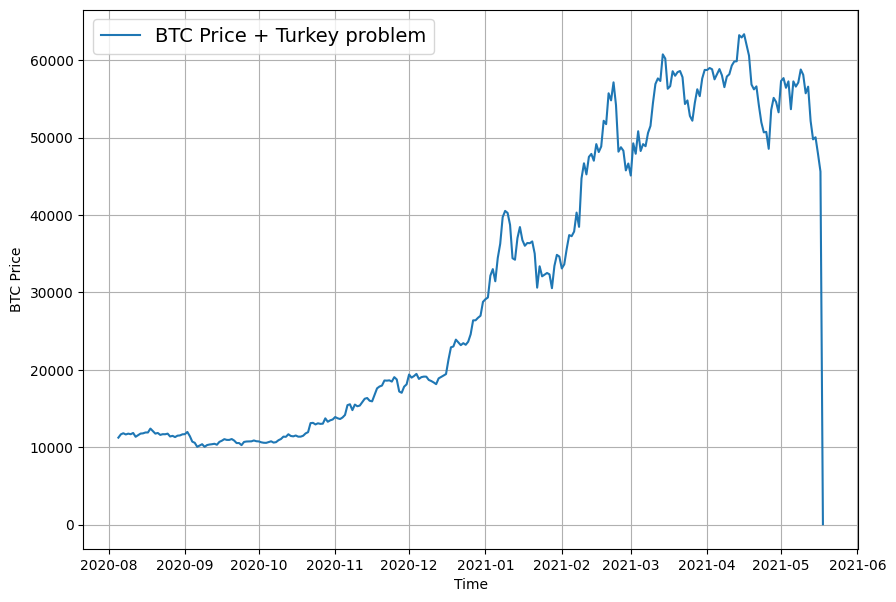

In [379]:
plt.figure(figsize = (10,7))
plot_time_series(timesteps = btc_timesteps_turkey,
                 values = btc_price_turkey,
                 format = "-",
                 label = "BTC Price + Turkey problem",
                 start = 2500)

In [380]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size = WINDOW_SIZE, horizon = HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Build the model

In [381]:
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_turkey_model"

turkey_model.compile(loss = "mae",
                     optimizer = "Adam"
                     )
turkey_model.fit(X_train, y_train,
                 epochs = 100,
                 verbose = 0,
                 batch_size = 128,
                 validation_data = (X_test, y_test))

In [382]:
# Evaluate on test data
turkey_model.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 294.6371


652.8074951171875

In [383]:
# Make predictions with turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8809.187, 8744.74 , 9006.847, 8741.271, 8694.753, 8688.983,
       8658.834, 8472.403, 8423.985, 8495.903], dtype=float32)>

In [384]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true = y_test,
                                y_pred = turkey_preds)
turkey_results

{'mae': 652.8075,
 'mse': 4881899.5,
 'rmse': 2209.502,
 'mape': 1.921257,
 'mase': 1.0091293}

In [385]:
model_1_results

{'mae': 564.72516,
 'mse': 1164158.1,
 'rmse': 1078.9615,
 'mape': 0.025392022,
 'mase': 0.99206567}

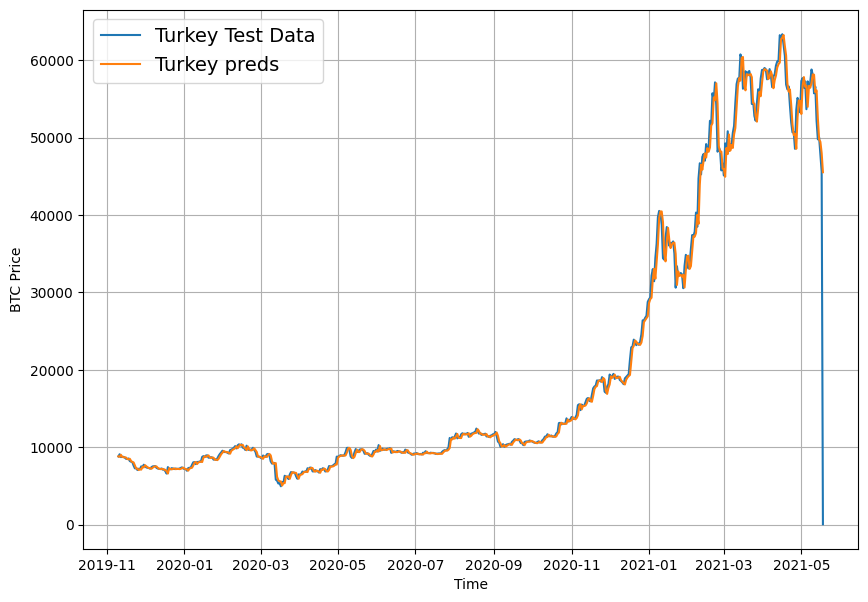

In [386]:
plt.figure(figsize = (10,7))
offset = 0
plot_time_series(timesteps = btc_timesteps_turkey[-len(y_test):],
                 values = btc_price_turkey[-len(y_test):],
                 format = "-",
                 label = "Turkey Test Data", start = offset)
plot_time_series(timesteps = btc_timesteps_turkey[-len(y_test):],
                 values = turkey_preds,
                 label = "Turkey preds",
                 start = offset);

## Comparing all the models


In [387]:
model_results = pd.DataFrame({"Naive model" : naive_results,
                              "Model_1_Dense_w7_h1": model_1_results,
                              "Model_2_Dense_w30_h1": model_2_results,
                              "Model_3_Dense_w30_h7": model_3_results,
                              "Model_4_CONV1D": model_4_results,
                              "Model_5_LSTM": model_5_results,
                              "Model_6_multivariate": model_6_results,
                              "Model_7_NBEATS": model_7_results,
                              "Model_8_ensemble": ensemble_results,
                              "Model_10_turkey": turkey_results}).T

model_results

,mae,mse,rmse,mape,mase
Naive model,567.980225,1.147547e+06,1071.236206,0.025165,0.999570
Model_1_Dense_w7_h1,564.725159,1.164158e+06,1078.961548,0.025392,0.992066
Model_2_Dense_w30_h1,612.770386,1.278164e+06,1130.558960,0.028069,1.071129
Model_3_Dense_w30_h7,612.496826,1.247528e+06,1116.927856,0.028593,1.115598
Model_4_CONV1D,17024.738281,5.108204e+08,22601.335938,0.846294,29.907749
Model_5_LSTM,586.406677,1.215315e+06,1102.413452,0.026308,1.030154
Model_6_multivariate,564.395569,1.158097e+06,1076.149170,0.025253,0.991487
Model_7_NBEATS,573.010071,1.180815e+06,1086.653320,0.025724,1.006620
Model_8_ensemble,568.236877,1.142589e+06,1068.919678,0.025608,0.998235
Model_10_turkey,652.807495,4.881900e+06,2209.501953,1.921257,1.009129


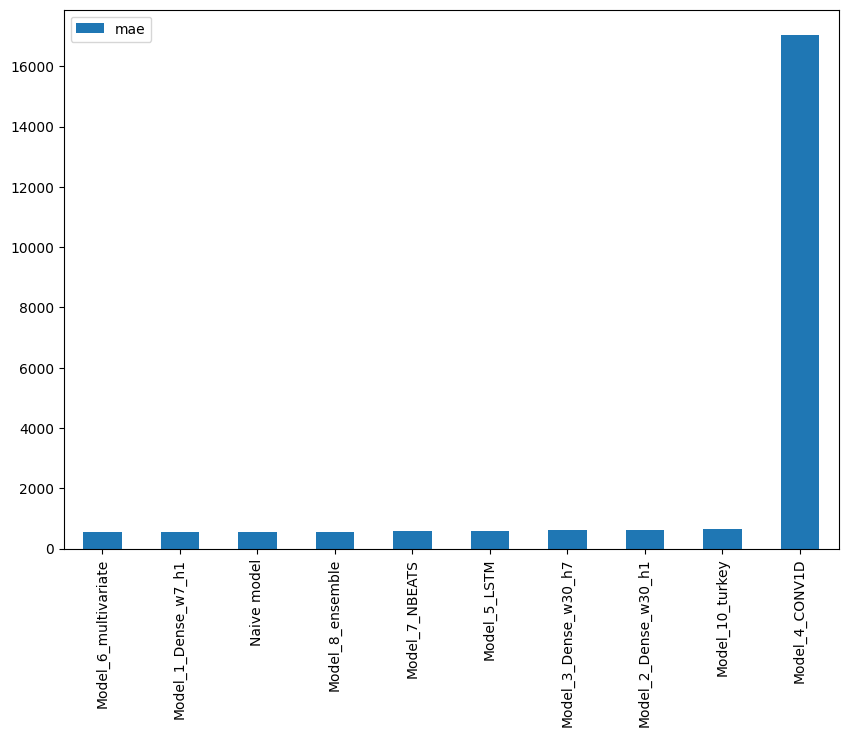

In [388]:
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

## Conclusion

Machine learning doesn't work really well in forecasting open systems since it really mostly predicts Yn+1 = Yn. This is why forecasting is such a complicated and oftentimes, inaccurate task. Taking an asset as volatile as bitcoin and trying to forecast it further proves this point.

As accurate as a prediction can be, it can never predict "Turkey moments", anomalies within the time series that throw off every prediction. While also altering subsequent models which take into account said outlier. From the previous notebook, I can say I've also learned the following:
* More complex models do not imply better results
* Deep learning doesn't work really well with time series forecasting on open systems (Perhaps Markov Chains would be better suited for this job).
* I've only scratched the surface and still got a lot to learn.